# NVIDIA AI Foundation Models Performance Analysis

The Nvidia **foundational Large Language Models** (LLMs) are hosted on the catalog.ngc.nvidia.com webpage.
Nvidia provides these models through either streaming or non-streaming process APIs for anyone
to interact with many models. Nvidia provides an API key to developers to interact with these 
LLMs without a cost such as the OPENAI API and the rate-limiting of OPENAI. This allows new developers to
experiment with LLMs with limited knowledge of the underlying architecture to obtain responses from 
prompts supplied.

In this notebook, we will look at 11 models that are labeled text-to-text models on their catalog. Since
all the APIs for the models are the same except the last path item which is the uuid for the model. These APIs
will be called using the Python requests module. Other request modules such as async with aiohttp, 
and httpx.

# Three main sections
1.  Run a set of prompts through a set of models and collect statistics data (non-prompt type specific).
2.  Run a set of 4 specific prompt scenarios (variation of input and output lengths) against all models and profile response behavior.
3.  Run a Gradio interface to send a query to specified models chosen in the UI. 


#### NOTE
There was experimentation with aiohttp with asyncio with the API calls. There are a few issues discovered:

    1. Some models will return a 200 status code instead of the expected 202. This required a rewrite to account
       for this problem.
       
    2. This problem is variable as it is not consistent with a particular model. If you want to async
       call the API for each model for a single prompt, one to a few of the models will return with an empty
       response. The amount of models that return an empty response will vary with each call.


In [1]:
import requests
import os, sys
import time
import json
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd 
import gradio as gr
from utils.llm_requests import ngc_request, ModelConfig, invoke_one_model, invoke_all_models
from utils.format_response import format_resp_single, format_resp_all

### Initialization 
In the cell below we will initialize our global variables that will be used by the LLM functions.

#### NOTE:
At the time of making this notebook, Mamba-chat had been released to the Nvidia catalog page on 02/12/2024.
It was not included in the set of testing due to the payload differing in structure from the other which will
require a rework to include.


In [2]:
# NGC Model file name (base folder should contain prompt csv, llm_models_file, and ngc_api_file.
base_file_path = './data/'          # Folder that contains the below files
llm_models_file = 'llm_models.yml'  # File containing all model names
ngc_api_file = 'ngc-api.yml'        # File containing ngc url + key info
csv_prompt_file = 'questions.csv'   # All prompts for section 1 
json_prompt_file = 'kv_cache_test.json' # File that stores scenario prompts for section 2

In [3]:
# Loading the llm_models data
with open(base_file_path + llm_models_file,'r') as f:
    model_data = yaml.load(f, Loader=yaml.SafeLoader)


In [25]:
# Run this cell if a yaml file exists that contains your API key to NGC. 
# Read in the NGC API file. One can supplement their file in their data directory. 
with open(base_file_path + ngc_api_file, 'r') as file:
    api_var = yaml.load(file, Loader = yaml.SafeLoader)

In [4]:
# Debugging to inspect what type the data read from the yaml files.
print(f"model_data is a {type(model_data)}, and api_var is a {type(api_var)}")

model_data is a <class 'dict'>, and api_var is a <class 'dict'>


In [5]:
# Initialize model URLs' dictionaries, model names, invoke URLs and API Key
model_urls = model_data['model_urls']
model_full_name = model_data['model_full_names'] # This variable is used for Gradio.
fetch_url_format = model_data['invoke-urls'][1]
my_api = api_var['NGCKEY']['API']

# One can also initialize their API key below by uncommenting the code below:
# os.environ['ngc_api'] = "your-key-here"
# my_api = os.environ.get['ngc_api']

In [6]:
# debug
# print(model_urls)
# print(10*'-')
# print(fetch_url_format)
# print(my_api)

### LLM Functions
Two main LLM functions interact with the Nvidia LLMs. All the models
are interfacing with Nvidia Triton. Some of the models indicate what GPU/GPUS are
used for the interfacing while some indicate others. Comparisons may not be "apple-to-apple"
due to not all models interfacing with the same hardware.

One function works by invoking a model name and a prompt to return the model
response. This works with a helper function that formats the response to be displayed in a more readable format.
This is all done by initializing the values into a class name "ModelConfig", model name, and model dictionary.

The second function is similar to the first model saves the output in the list of dictionaries with a
similar human-readable format. 

#### Testing the LLM invocation model
In the next two cells below, one can call the function by supplying a model and prompt. The second cell
allows the user just to specify a prompt and make the call to all models in the model dictionary.

In [7]:
# Test the invocation of the NGC API to the models
test_str = "Describe the company, Nvidia."

# Do one model call to test the connection
test_model_name = "nv-llama2-70b-rlhf"

# This class contains the prompt, API, temperature, top_p, max_tokens, seed, and stream configurations.
test_model_config = ModelConfig(test_str, my_api)

In [8]:
# Call the model that uses a single model and prompt. Time the response.
s1_time = time.time()
llm_response = format_resp_single(test_model_name, test_model_config, model_urls)
s2_time = time.time()

print("Total time taken: {} seconds. Note actual response time from AI foundations is used in analysis \
        \n".format(round((s2_time - s1_time),3)))
print(llm_response)

Total time taken: 11.193 seconds. Note actual response time from AI foundations is used in analysis         

Nvidia is an American technology company that specializes in the design and manufacturing of graphics processing units (GPUs) and other related products. Founded in 1993, Nvidia has become a leading player in the computer hardware industry, with a focus on developing advanced GPUs for gaming, professional visualization, data center, and automotive applications.

Nvidia's GPUs are widely used in a variety of industries, including gaming, film and video production, scientific research, and artificial intelligence. The company's flagship product line, the GeForce GPUs, are popular among gamers and are used in many high-end gaming computers and laptops. Nvidia also produces Quadro GPUs for professional visualization and Tesla GPUs for data center and artificial intelligence applications.

In addition to GPUs, Nvidia also offers a range of other products, including the Jetson platfo

#### Doing a test run of a single prompt through all models specified in YAML file


In [9]:
# Call the function that uses a single prompt that iterates through all models. Time the response.
s3_time = time.time()
llm_all_resp = format_resp_all(test_model_config, model_urls)
s4_time = time.time()

print("Total time taken: {} minutes\n ".format(round((s4_time-s3_time) / 60,3)))
print(llm_all_resp)

Total time taken: 0.912 minutes
 
Model Name: nv-llama2-70b-rlhf  Response Time:0.149 seconds  #Input Tokens:38  #Output Tokens:331

 Model Name: yi-34b  Response Time:0.323 seconds  #Input Tokens:138  #Output Tokens:305

 Model Name: nemotron-3-8b-QA  Response Time:0.613 seconds  #Input Tokens:143  #Output Tokens:276

 Model Name: llama213b  Response Time:0.615 seconds  #Input Tokens:149  #Output Tokens:261

 Model Name: mixtral8x7binstruct  Response Time:1.347 seconds  #Input Tokens:61  #Output Tokens:368

 Model Name: llama270b  Response Time:2.279 seconds  #Input Tokens:16  #Output Tokens:524

 Model Name: nv-llama2-70b-steerlm  Response Time:2.494 seconds  #Input Tokens:123  #Output Tokens:359

 Model Name: mistral7binstruct  Response Time:4.839 seconds  #Input Tokens:61  #Output Tokens:402




# 1. Creating benchmark datasets - collect results for all models over all prompts

The section below creates the LLM results dataframes and LLM benchmark results.

The function **create_llm_dataset** generates a pandas dataframe when provided a csv or json file 
containing the input_prompt and model configurations for the eleven (11) text-to-text models.

The function **create_stats_llm** generates a pandas dataframe from the dataframe created by
create_llm_dataset that contains the statistical info of each model concerning response time
and output_tokens.

The function **df_save** saves the files created from the two functions above to a specified folder 
as json files.

In [17]:
def create_llm_dataset(file_path:str, model_urls:dict) -> pd.DataFrame: 
    """
    Creates a data frame that is the product of running multiple
    prompts through all the models and returns the response
    message, model response time, and output tokens.

    Args:
        file_path (str): CSV | JSON file path prompts and llm model configurations.

    Outputs:
        df_llm (pd.DataFrame): Output data frame of all prompts apply.
                               to the function of calling all LLM models.

    """
    # Read in CSV prompt data and convert to list to process
    if file_path.endswith('.csv'):
        df_prompts = pd.read_csv(file_path, sep=",")
    elif file_path.endswith('.json'):
        df_prompts = pd.read_json(file_path)
 

    lst_responses = [] # list to collect responses from all models (per prompt)
    # Iterate through all prompts and get responses from all models
    print("Starting LLM API calls")
    for counter, row in enumerate(df_prompts.itertuples()):
        # Intialize the model configurations.
        prompt_config = ModelConfig(row.questions, my_api, row.temperature, row.top_p, row.max_tokens, row.seed, row.stream)
        
        # Sending a single prompt to all selected models (output is a list of dictionaries)
        full_llm_res = invoke_all_models(prompt_config, model_urls)
        
        # Collecting all responses from all models as a list of dictionaries for a single prompt.
        lst_responses.append(full_llm_res)
        print("Completed {} rounds".format(counter+1))

    
    lst_pd = [] # list of responses for all prompts to be read into pandas
    
    # Decompose list of list of dictionaries to a single list of dictionaries for dataframe processing 
    for sublist in lst_responses:
        for item in sublist:
            lst_pd.append(item)

    df_llm = pd.DataFrame(lst_pd) # Create the dataframe.
    # Add the classification to each model run.
    if file_path.endswith('.json'):
        model_len = len(df_llm['model_name'].unique())
        classes = ['short-in -> short-out'] * model_len + ['short-in -> long-out'] * model_len  + ['long-in -> short-out'] * model_len + ['long-in -> long-out'] * model_len
        df_llm['class'] = classes

    return df_llm
        

In [18]:
def create_stats_llm(llm_df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a data frame that is a merge of two pandas groupby 
    dataframes of response time and output token.

    Args: 
        llm_df (pd.DataFrame): Pandas dataframe of LLM responses.

    Outputs:
        stats_df (pd.DataFrame): Pandas dataframe of LLM aggregation stats.
    
    """
    # Group by the response time for each model and take three statistical measures for response time.
    time_df = llm_df.groupby("model_name")['resp_time'].aggregate(resp_time_min='min',
                                                                  resp_time_max='max',resp_time_mean='mean')
    time_df = time_df.reset_index()
    time_df = time_df.sort_values('resp_time_mean', ascending=True).reset_index(0, drop=True)

    # Group by the output tokens for each model and take three statistical measures for output tokens.
    tkn_df = llm_df.groupby("model_name")['out_tokens'].aggregate(out_tkn_min="min", out_tkn_max="max", out_tkn_mean="mean")
    tkn_df = tkn_df.reset_index()
    tkn_df = tkn_df.sort_values("out_tkn_mean", ascending=True).reset_index(0, drop=True)

    # Merge both dataframes into one dataframe for ease of use.
    stats_df = time_df.merge(tkn_df, how="inner", on="model_name")

    return stats_df
    

In [19]:
def df_save(llm_df: pd.DataFrame, stats_llm: pd.DataFrame) -> None:
    """
    Saves two data frames to separate json files.

    Args:
        llm_df (pd.DataFrame): pandas dataframe of LLM responses
        stats_llm (pd.DataFrame): pandas dataframe of LLM aggregation stats.
        
    """
    # Create a folder to store the outputs.
    folder_path = "./output_llm/"
    os.makedirs(folder_path, exist_ok = True)

    # Saving the inputs from llm_results and stats_llm.
    llm_df.to_json(folder_path + "results_llm.json", orient = "records", compression = "infer")

    stats_llm.to_json(folder_path + "stats_llm.json", orient = "records", compression = "infer")


### Sending the prompt request for all prompt data over all models 
Below this cell, it will call the above dataframe functions to create the 
data structure we need to get the statistical info concerning the models used

In [20]:
# The CSV file has five rows of prompt data.
csv_path = base_file_path + csv_prompt_file # Setting the csv path.

start_tm = time.time() 
# Create the LLM results dataframe. (#prompts x #models)
df_llm = create_llm_dataset(csv_path, model_urls)

# Create the Statistical LLM dataframe. (#models x 6-statistical measures)
llm_stats = create_stats_llm(df_llm)

end_tm = time.time() 
elapsed_time = (end_tm - start_tm) / 60
print("Elapsed time to run benchmark: {} minutes".format(round(elapsed_time,3)))

# Save the data structures to json.
df_save(df_llm, llm_stats)

Starting LLM API calls
Completed 1 rounds
Completed 2 rounds
Completed 3 rounds
Completed 4 rounds
Completed 5 rounds
Elapsed time to run benchmark: 5.523 minutes


In [21]:
# Show the benchmark dataframe for the LLM models.
print("Benchmark statistics for the LLM Models.")
print(f"Shape of llm_stats dataframe is {llm_stats.shape}")
llm_stats

Benchmark statistics for the LLM Models.
Shape of llm_stats dataframe is (8, 7)


,model_name,resp_time_min,resp_time_max,resp_time_mean,out_tkn_min,out_tkn_max,out_tkn_mean
0,llama270b,0.118,4.061,1.3888,456,822,676.4
1,mixtral8x7binstruct,0.692,3.793,1.8046,135,487,371.0
2,nemotron-3-8b-QA,0.120,4.672,1.9184,242,555,379.6
3,llama213b,0.816,3.800,2.2338,166,591,413.8
4,mistral7binstruct,0.127,4.918,2.4100,136,491,355.6
5,nv-llama2-70b-steerlm,0.949,4.436,2.6446,325,584,455.6
6,yi-34b,1.021,4.605,3.2706,250,475,396.8
7,nv-llama2-70b-rlhf,0.129,5.016,3.3620,276,326,295.6


In [22]:
print("Snapshot of the LLM Results from multiple prompts.")
df_llm.head(15)

Snapshot of the LLM Results from multiple prompts.


,model_name,resp_time,out_tokens,in_tokens,prompt,message
0,mixtral8x7binstruct,2.502,341,63,What are the top tourist attractions in Paris?,"I'm here to provide you with accurate, helpful..."
1,mistral7binstruct,4.732,360,63,What are the top tourist attractions in Paris?,I'm glad you're asking about tourist attractio...
2,nv-llama2-70b-rlhf,0.129,326,41,What are the top tourist attractions in Paris?,Some of the top tourist attractions in Paris i...
3,nv-llama2-70b-steerlm,2.865,584,126,What are the top tourist attractions in Paris?,Paris is a city that is renowned for its rich ...
4,llama213b,1.431,555,152,What are the top tourist attractions in Paris?,"Hello! As a helpful and respectful assistant, ..."
5,llama270b,0.118,733,19,What are the top tourist attractions in Paris?,"Paris, the capital of France, is known for its..."
6,yi-34b,1.021,336,140,What are the top tourist attractions in Paris?,"Paris is renowned for its rich history, stunni..."
7,nemotron-3-8b-QA,4.672,462,145,What are the top tourist attractions in Paris?,Paris is one of the most beautiful and histori...
8,mixtral8x7binstruct,3.793,135,69,How does the Eiffel Tower contribute to the ci...,The Eiffel Tower significantly contributes to ...
9,mistral7binstruct,1.716,136,69,How does the Eiffel Tower contribute to the ci...,The Eiffel Tower is an iconic landmark and a s...


# 2. Prompt scenario performance experiment.

Now, it is time to the feed json data containing four scenarios pretraining to the length of the input and output tokens.
The scenarios are listed as follows:
 - short input -> short output
 - short input -> long output
 - long input -> short output
 - long input -> long output

**NOTE**: There appears to be an issue if max_tokens is set above 1024, it returns a 422 HTTP Error. 


In [23]:
# Initialize json file path. This file contains four JSON items.
json_path = base_file_path + json_prompt_file

# Create the LLM results dataframe for the scenarios. Dataframe size is (4 X #models) x 6 data columns 
start_time = time.time()
df_llm_kv = create_llm_dataset(json_path, model_urls)
end_time = time.time()

elapsed_time_f = (end_time - start_time) / 60
print("Elapsed time to run benchmark: {} minutes".format(round(elapsed_time_f,3)))
print("Rows: {}, Columns: {}".format(df_llm_kv.shape[0], df_llm_kv.shape[1]))

Starting LLM API calls
Completed 1 rounds
Completed 2 rounds
Completed 3 rounds
Completed 4 rounds
Elapsed time to run benchmark: 6.24 minutes
Rows: 32, Columns: 7


In [24]:
# Inspect the dataframe to check for the validity of the dataframe transformation.
df_llm_kv.head(10)

,model_name,resp_time,out_tokens,in_tokens,prompt,message,class
0,mixtral8x7binstruct,0.291,451,110,How has the evolution of digital technology in...,The evolution of digital technology has signif...,short-in -> short-out
1,mistral7binstruct,0.509,478,110,How has the evolution of digital technology in...,"The evolution of digital technology, particula...",short-in -> short-out
2,nv-llama2-70b-rlhf,0.150,487,89,How has the evolution of digital technology in...,The evolution of digital technology has had a ...,short-in -> short-out
3,nv-llama2-70b-steerlm,0.420,512,174,How has the evolution of digital technology in...,The evolution of digital technology has had a ...,short-in -> short-out
4,llama213b,4.018,455,200,How has the evolution of digital technology in...,The evolution of digital technology has signif...,short-in -> short-out
5,llama270b,2.168,511,67,How has the evolution of digital technology in...,The evolution of digital technology has signif...,short-in -> short-out
6,yi-34b,1.496,366,186,How has the evolution of digital technology in...,The evolution of digital technology has had a ...,short-in -> short-out
7,nemotron-3-8b-QA,2.755,379,189,How has the evolution of digital technology in...,The evolution of digital technology has had a ...,short-in -> short-out
8,mixtral8x7binstruct,4.283,657,111,How has the evolution of digital technology in...,The evolution of digital technology has signif...,short-in -> long-out
9,mistral7binstruct,3.961,763,111,How has the evolution of digital technology in...,Title: The Digital Revolution: Transforming Co...,short-in -> long-out


# Charts of the results.
Let us take a look at the results through Matplotlib. The cells below will display seven
different plots of the response time vs input and output tokens and complete tokens (input and output tokens).

### Initialize plots variables.

In [26]:
# Copy the dataframe to a variable to use in plotting.
df = df_llm_kv

## Defining plot values
markers = [
    "o",  # Circle
    "s",  # Square
    "^",  # Triangle Up
    "P",  # Plus (filled)
    "*",  # Star
    "$\clubsuit$",  # Club symbol using LaTeX
    "X",  # X (filled)
    "D",  # Diamond
    "p",  # Pentagon
    "H",  # Hexagon
    "v",  # Triangle Down
    "+"   # Plus
]

marker_size = 100  # Size of markers

# Set the colors magenta, light green, orangered, and blue into a numpy array
colors = np.array([[1.0, 0.0, 1.0, 1.0],
                   [0.0, 0.5, 0.0, 1.0],
                   [1.0, 0.27, 0.0, 1.0],
                   [0.0, 0.0, 1.0, 1.0]])


# Unique values for model_name and class
unique_models = df['model_name'].unique()
unique_classes = df['class'].unique()

# Markers and colors to be used in the subplots.
m_subplots = markers[:len(unique_models)]
c_subplots = ['magenta', 'green', 'orangered', 'blue']

# Line style and width for grid lines.
line_style, line_width = "--", 1.0

## Subplots of Output Tokens vs Response Time

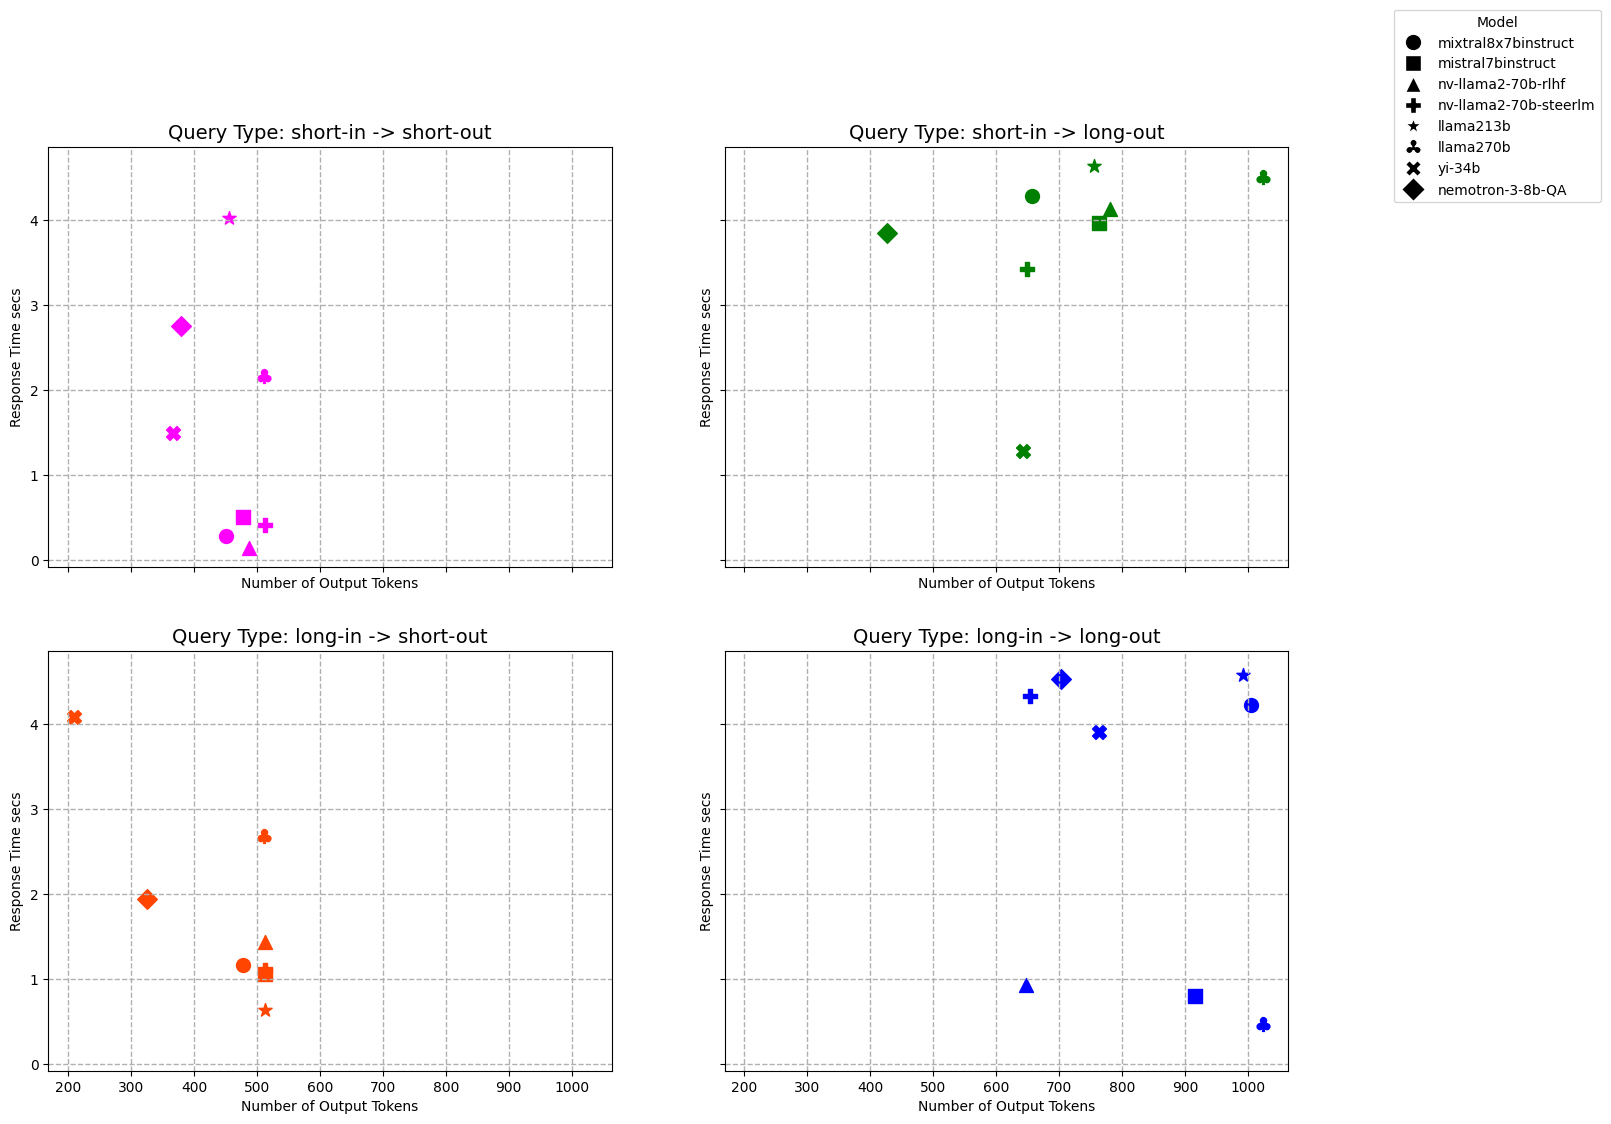

In [27]:
# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
axs = axs.flatten()

# Loop through each class for plotting
for i, class_value in enumerate(unique_classes):
    ax = axs[i]
    subset = df[df['class'] == class_value]
    
    # Plot each model with a different marker
    for j, model in enumerate(unique_models):
        model_subset = subset[subset['model_name'] == model]
        ax.scatter(model_subset['out_tokens'], model_subset['resp_time'], 
                   marker=m_subplots[j], color=c_subplots[i], label=model, s=marker_size)
    
    # Label the axes
    ax.set_title(f'Query Type: {class_value}', fontsize=14)
    ax.grid(axis='both', linewidth = line_width, linestyle = line_style)
    ax.set_xlabel('Number of Output Tokens')
    ax.set_ylabel('Response Time secs')

legend_elements = [Line2D([0], [0], marker=markers[i], color='w', label=unique_models[i],
                          markerfacecolor='k', markersize=12) for i in range(len(unique_models))]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.1, 1), title='Model')
plt.savefig('output_llm/response_time-vs-out_tokens-subplots.png')
plt.show()

## Subplots of Input Tokens vs Response Time

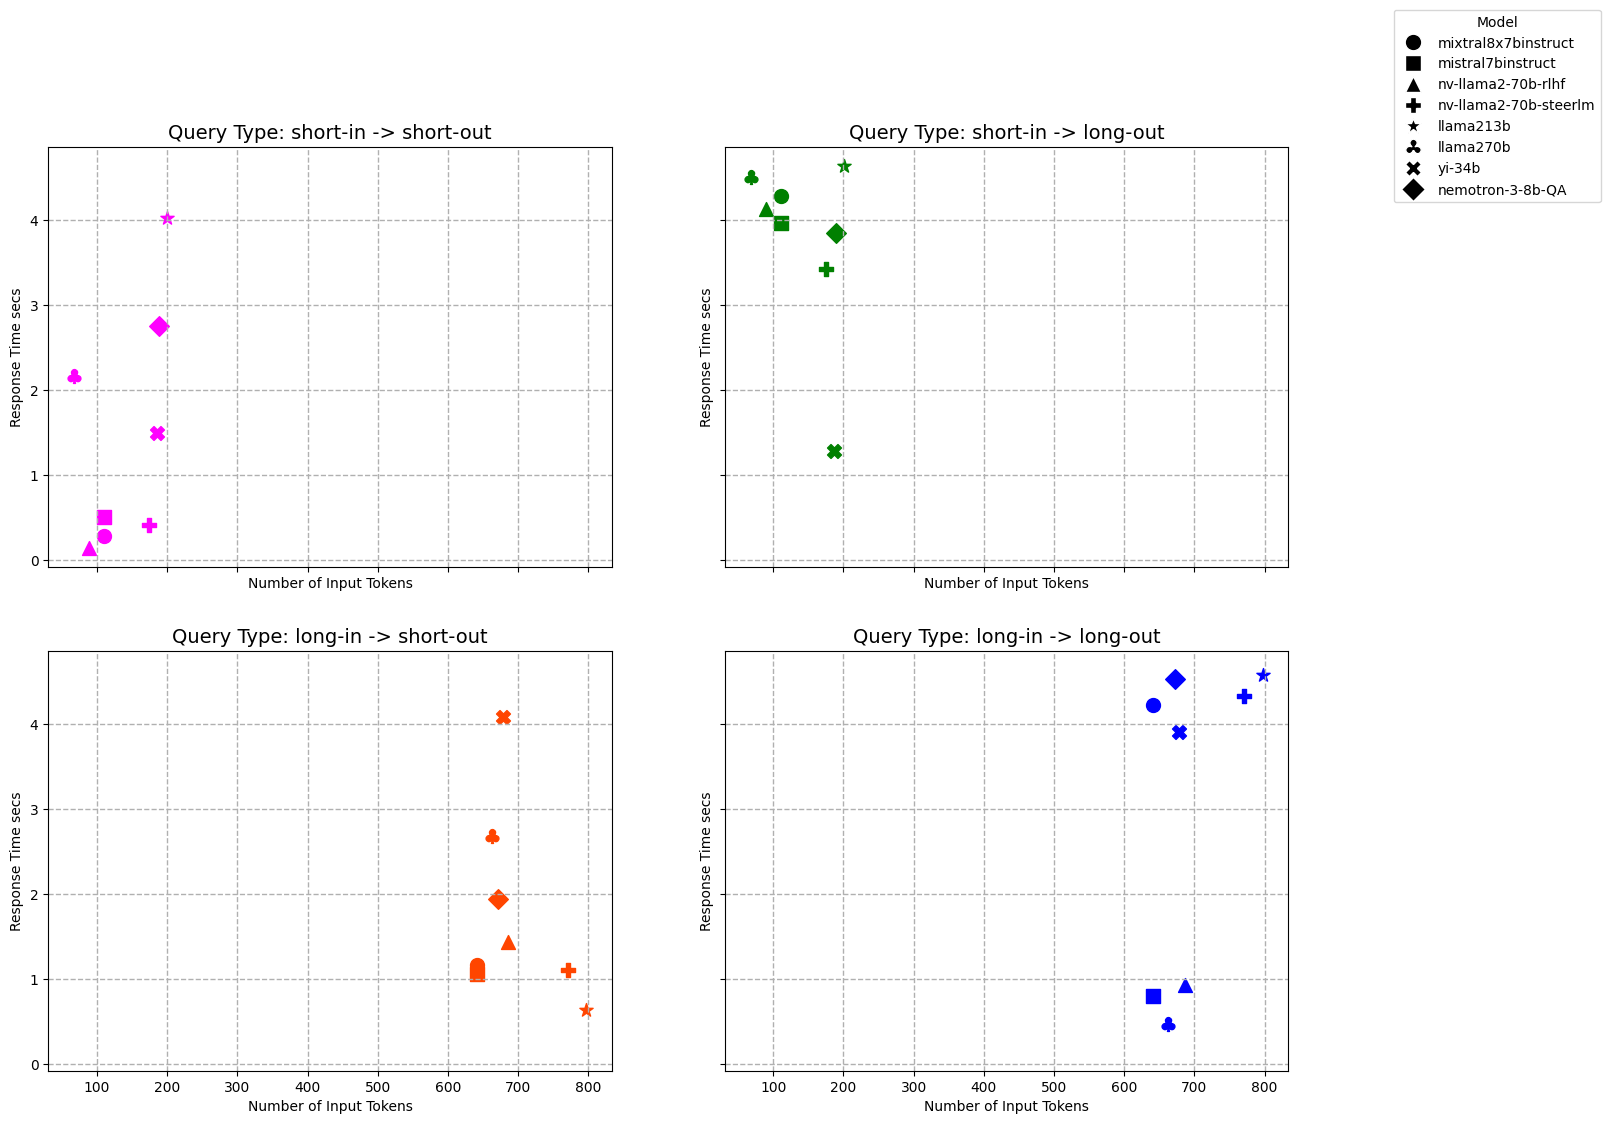

In [28]:
# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
axs = axs.flatten()

# Loop through each class for plotting
for i, class_value in enumerate(unique_classes):
    ax = axs[i]
    subset = df[df['class'] == class_value]
    
    # Plot each model with a different marker
    for j, model in enumerate(unique_models):
        model_subset = subset[subset['model_name'] == model]
        ax.scatter(model_subset['in_tokens'], model_subset['resp_time'], 
                   marker=m_subplots[j], color=c_subplots[i], label=model, s=marker_size)
    
    # Label the axes
    ax.set_title(f'Query Type: {class_value}', fontsize=14)
    ax.grid(axis='both', linewidth = line_width, linestyle = line_style)
    ax.set_xlabel('Number of Input Tokens')
    ax.set_ylabel('Response Time secs')

legend_elements = [Line2D([0], [0], marker=markers[i], color='w', label=unique_models[i],
                          markerfacecolor='k', markersize=12) for i in range(len(unique_models))]

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.1, 1), title='Model')
plt.savefig('output_llm/response_time-vs-in_tokens-subplots.png')
plt.show()

## Response time vs number of input tokens across all models

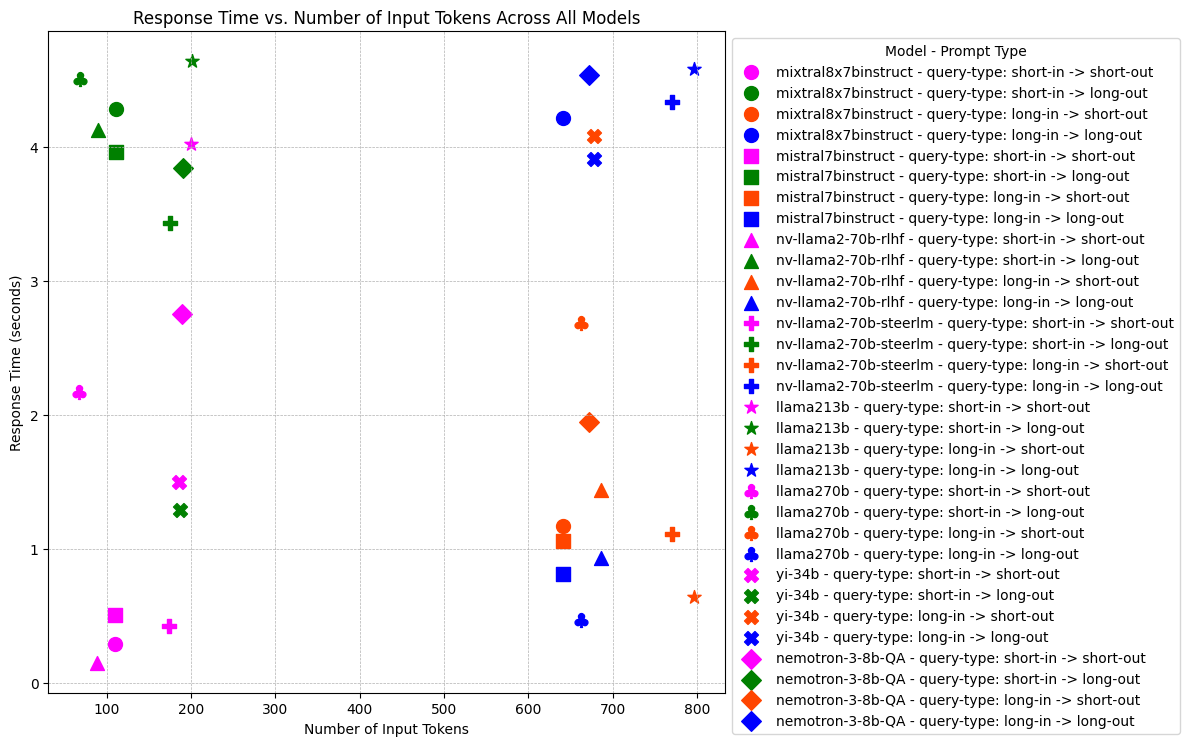

In [29]:
plt.figure(figsize=(12, 8)) # Create a scatter plot

# Loop over each unique model_name
for i, model in enumerate(df['model_name'].unique()):
    # Subset the DataFrame based on model_name
    subset = df[df['model_name'] == model]
    
    # Loop over each unique prompt_id within the subset
    for j, prompt_id in enumerate(subset['class'].unique()):
        prompt_subset = subset[subset['class'] == prompt_id]
        
        # Plot using a different marker and color for each prompt_id
        plt.scatter(prompt_subset['in_tokens'], prompt_subset['resp_time'], label=f"{model} - query-type: {prompt_id}",
                    marker=markers[i % len(markers)], color=colors[j % len(colors)], s=marker_size)

# Labeling axes and title
plt.xlabel('Number of Input Tokens')
plt.ylabel('Response Time (seconds)')
plt.title('Response Time vs. Number of Input Tokens Across All Models')

# Place the legend outside the plot on the right side
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Model - Prompt Type')
plt.grid(axis='x', linewidth = 0.5, linestyle = '--')
plt.grid(axis='y', linewidth = 0.5, linestyle = '--')
plt.tight_layout()  # Adjust layout to not cut off the legend
plt.savefig('output_llm/response_time-vs-in_tokens-all.png') # Save the image.
plt.show()

# Response time vs number of output tokens across all models

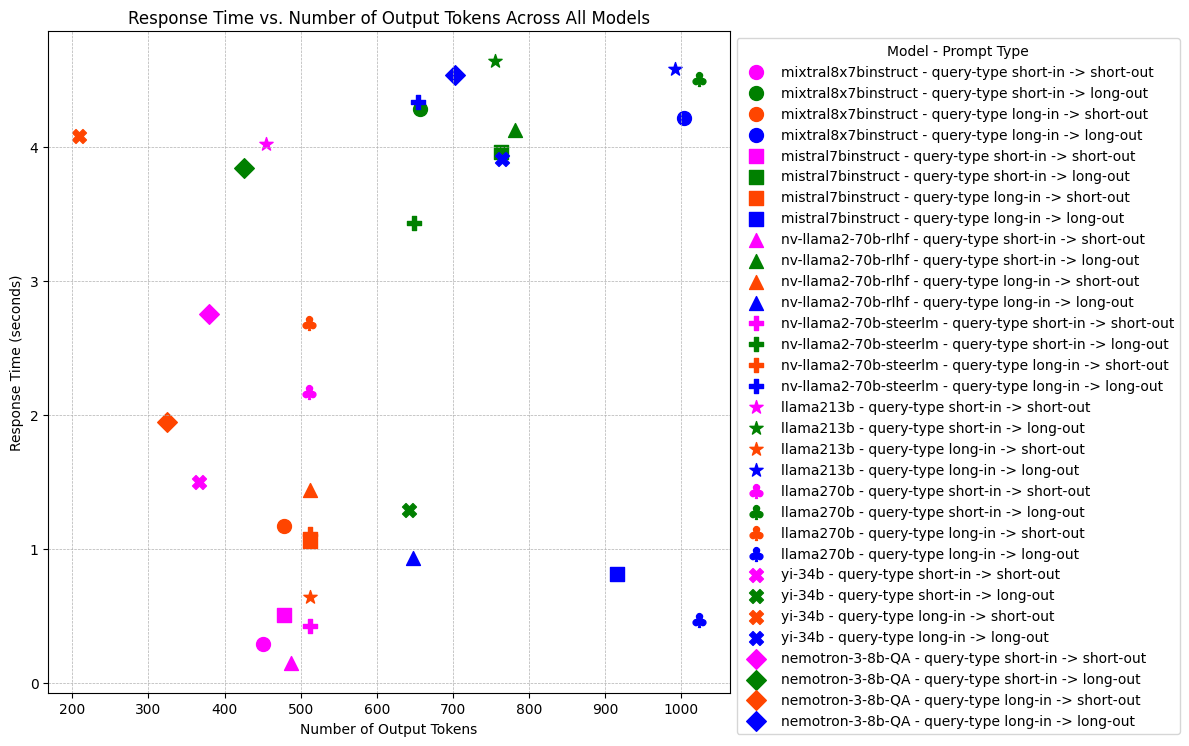

In [30]:
# Create a scatter plot
plt.figure(figsize=(12, 8))

# Loop over each unique model_name
for i, model in enumerate(df['model_name'].unique()):
    # Subset the DataFrame based on model_name
    subset = df[df['model_name'] == model]
    
    # Loop over each unique prompt_id within the subset
    for j, prompt_id in enumerate(subset['class'].unique()):
        prompt_subset = subset[subset['class'] == prompt_id]
        
        # Plot using a different marker and color for each prompt_id
        plt.scatter(prompt_subset['out_tokens'], prompt_subset['resp_time'], label=f"{model} - query-type {prompt_id}",
                    marker=markers[i % len(markers)], color=colors[j % len(colors)], s=marker_size)

# Labeling axes and title
plt.xlabel('Number of Output Tokens')
plt.ylabel('Response Time (seconds)')
plt.title('Response Time vs. Number of Output Tokens Across All Models')

# Place the legend outside the plot on the right side
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Model - Prompt Type')

plt.tight_layout()  # Adjust layout to not cut off the legend
plt.grid(axis='x', linewidth = 0.5, linestyle = '--')
plt.grid(axis='y', linewidth = 0.5, linestyle = '--')
plt.savefig('output_llm/response_time-vs-out_tokens-all.png') # Save the image.
plt.show()

# 3. Gradio Interface

This section will present the functions of the LLMs as an interface through radio.

1. Users will select which model to use which allows them to enter a prompt to return 
   the result.

2. The function that invokes all the LLM will present the fastest models from top to bottom
   as a quick visual as to which model is best for the particular prompt.

**NOTE**: Functions had to be re-written to work with Gradio so that there are two functions in the notebook 
          that function similarly.



### Gradio Functions

In [44]:
def llm_invoke_all(prompt:str):
  """
    This function will call from any model within the dictionary from Nvidia
    AI foundational models and run the model. This is strictly focused on
    the text-to-text models found on the link below:

    https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models

    Models that require context are not included in the dictionary.

    Args:
        prompt (str) -> Prompt to be passed to the model.

    Outputs
        msg (str) -> text generated from the model given the prompt.
        resp_time (str) -> time taken to generate the response.
        input_tokens (int) -> number of tokens generated by the user input.
        out_tokens (int) -> number of tokens produced by the LLM.
        model_name (str) -> name of the model that was called by the curl request.
        prompt (str) -> prompt used to generate the output.

  """

  headers = {
    "Authorization": "Bearer " + str(my_api),
    "Accept": "application/json",
  }

  payload = {
  "messages": [
    {
      "content": str(prompt),
      "role": "user"
    }
  ],
  "temperature": 0.2,
  "top_p": 0.7,
  "max_tokens": 1024,
  "seed": 42,
  "stream": False
  }

  lst_resp = [] # Initialize list for the main output.
    
  #Create session.
  session = requests.Session()

  # Issue: function had to be rewritten to solve None results from output_tokens.   
  for key, url in model_urls.items():
    tmp_dict = {}
    response = session.post(url, headers = headers, json = payload)

    while response.status_code == 202:
      request_id = response.headers.get("NVCF-REQID")
      fetch_url = fetch_url_format + request_id
      response = session.get(fetch_url, headers=headers)

    response.raise_for_status()
    response_body = response.json()
    msg = response_body.get('choices')[0].get('message').get('content')
    resp_time = round(response.elapsed.total_seconds(), 3)
    out_tokens = response_body.get('usage').get('completion_tokens')
    in_tokens = response_body.get('usage').get('prompt_tokens')
    tmp_dict = {"model_name": key,"resp_time": resp_time, "out_tokens": out_tokens,
                "in_tokens": in_tokens, "prompt": prompt, "resp_msg": msg}
    lst_resp.append(tmp_dict)
    time.sleep(0.2)

  return lst_resp

def llm_invoke(model_name:str, prompt:str):
    
    """
    This function will call from any model within the dictionary from Nvidia
    AI foundational models and run the model. This is strictly focused on
    the text-to-text models found on the link below:

    https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models

    Models that require context are not included in the dictionary.

    Args:
        model_name (str): name of the model
        prompt (str): prompt to be passed to the model

    Outputs:
    Dictionary of the following outputs.
        model_name (str): name of the model
        resp_time (str): time taken to generate the response
        out_tokens (int): number of tokens returned from the LLM.
        in_tokens (int): number of tokens that represent the prompt.
        prompt (str): input string to be ingested by the LLM.
        msg (str): text generated from the model given the prompt

    """
    # Initialize the headers and payloads for the CURL requests.
    headers = {
        "Authorization": "Bearer " + str(my_api),
        "Accept": "application/json",
     }

    payload = {
        "messages": [
        {
            "content": str(prompt),
             "role": "user"
        }
    ],
    "temperature": 0.2,
    "top_p": 0.7,
    "max_tokens": 1024,
    "seed": 42,
    "stream": False
    }

    # Error catching if not model is not list of models.
    model_name = model_name.lower().replace(" ","")
    if model_name not in model_urls.keys():
        print("Model name not found in dictionary, using default model")
        print("Default model is NV-Llama2-70B-RLHF")
        model_name = "nv-llama2-70b-rlhf"
    model_url = model_urls[model_name]
    
    model_session = requests.Session()
    
    return ngc_request(model_session, model_url, headers, payload, model_name, prompt)

def gradio_all(prompt: str, save_as_file=False):
    """
    Formats the output to human readable style when a prompt is sent
    to all models

    Args
        prompt: string input from the user.
        save_as_file: boolean for the user to click checkbox to save the file.
    """
    content_lst = list() # Initialize an empty list.
    response_lst = llm_invoke_all(prompt) # Call the function. 
    response_lst = sorted(response_lst, key=lambda x: x['resp_time'], reverse = False) # Sort by response time.
    save_json(response_lst, save_as_file) # Call the save file function.
    for doc in response_lst:
        content = f"Model Name: {doc['model_name']}  Response Time:{doc['resp_time']} seconds\n  #Input Tokens:{doc['in_tokens']}  #Output Tokens:{doc['out_tokens']}\n\n"
        content_lst.append(content)
    return " ".join(content_lst)

def save_json(data, save_as_file):
    """
    Gives the option in Gradio to save output to JSON.

    Args
        data (dict | list): either a dictionary or a list of dictionaries
        save_as_file (bool): boolean for the user to click the checkbox to save the file.
    """
    
    json_data = json.dumps(data)
    if save_as_file:
        with open('./data/response_llm.json', 'w') as file:
            file.write(json_data)
        return "File Saved Successfully"
    else:
        return json_data

def gradio_one(model_name:str, prompt:str, save_as_file=False):
    """
    Formats the output to a human-readable style when a model is selected
    get a generated output.

    Args:
        model_name (str): model name that is being invoked
        prompt (str): string containing the human input text.
        save_as_file (bool): boolean for the user to click the xcheckbox to save the file.
    """
    # Call the model and format the output by calling the key values.
    llm_out = llm_invoke(model_name, prompt)
    
    output = f"{llm_out['message']}\n\nResponse time: {llm_out['resp_time']} seconds\n\n #Output Tokens:{llm_out['out_tokens']}  #Input Tokens:{llm_out['in_tokens']}\n  Model Name:{llm_out['model_name']}"
    save_json(llm_out, save_as_file)
    return output

### Gradio Interface: Single Model with prompt with option to save result.

In [38]:
iface_singular = gr.Interface(fn = gradio_one,
                     inputs =[gr.Radio(list(model_full_name.values()), label="Model Name"),
                              gr.Textbox(label="Enter your Prompt"),
                              gr.Checkbox(label="Save as File")],
                     outputs = gr.Textbox(label="LLM Output"),
                     title = "Nvidia LLM Invoker",
                     description = "Choose a model and enter a prompt to invoke a LLM model from Nvidia AI Foundational Models.")

iface_singular.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [39]:
iface_singular.close()

Closing server running on port: 7861


### Gradio Interface: Single Prompt across all models with option to save result.

In [46]:
iface_llm = gr.Interface(fn = gradio_all,
                         inputs = [gr.Textbox(label="Enter your Prompt"),
                                   gr.Checkbox(label="Save as file")],
                         outputs = gr.Textbox(label="Best Performing LLMs with respect to time."),
                         title = "Nvidia Multi-Model Invoker",
                         description = "Enter a prompt to invoke multiple LLMs from Nvidia AI Foundational Models and return the response times."
)

iface_llm.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [45]:
iface_llm.close()

Closing server running on port: 7861


# Conclusion and Additonal Work.

In this notebook, we were able to test multiple models from the NGC AI foundational models catalog against many prompts.
We were able to plot the results of the test to see how models perform in different scenarios as well as benchmark models
using statistical measures to see which were the best-performing models concerning response time.

Here is some additional work that can be done to improve this notebook:

* Refactor code so that the request function to send prompts to NGC models works with or without Gradio. The current code had to be separated into two separate functions that perform the same function.

* Extend the functionality to other types of models on the Nvidia catalog. This notebook focused on text-to-text models where the model payloads were of the same structure.

* Add functionality to allow for async CURL requests to the API. Encountered two bugs when working the modules async and aiohttp. The explanation can be found at the top of the notebook.

* Add functionality to evaluate the metrics of each LLM model using Information Retrieval metrics such as MMR, BLEU, ROUGE, and some others.

* Add functionality for these models to be evaluated by certain packages such as [AlpacaEval](https://github.com/tatsu-lab/alpaca_eval)